In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras.backend as K
from keras.layers import Layer
from sklearn.svm import SVR


In [0]:
np.random.seed(7)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# change data here
ticker = '/content/drive/My Drive/ALK.csv'
df = pd.read_csv(ticker)
df = df.drop(df.columns[0], axis=1)

#corr
fields = ['open', 'high', 'low', 'close', '5 period SMA', '10 period SMA', '50 period SMA', '100 period SMA', 'On Volume Balance']

x = df[fields]
x.head(10)

open    high      low  close  5 period SMA  10 period SMA  50 period SMA  \
0  58.81  60.800  58.1400  60.35        59.330         59.413        56.4770   
1  60.35  60.450  58.6400  59.58        59.920         59.350        56.7126   
2  59.69  61.690  59.2600  61.14        59.924         59.559        56.9620   
3  61.05  61.250  60.0300  60.88        60.132         59.677        57.2036   
4  61.29  62.130  60.1100  60.24        60.438         59.763        57.4312   
5  60.42  61.230  59.8500  60.66        60.500         59.915        57.6540   
6  60.68  61.550  60.6800  61.16        60.816         60.368        57.9030   
7  61.22  61.784  60.5835  61.64        60.916         60.420        58.1562   
8  61.64  61.970  59.3600  59.73        60.686         60.409        58.3448   
9  60.10  60.850  59.5700  60.70        60.778         60.608        58.5738   

   100 period SMA  On Volume Balance  
0       50.712828          -11786400  
1       50.801500          -10978500  
2       50.990200          -11675800  
3       51.173400          -10811600  
4       51.349700          -10124400  
5       51.528800          -10858700  
6       51.715400          -11534700  
7       51.905900          -12100700  
8       52.078500          -11481500  
9       52.260300          -12307100

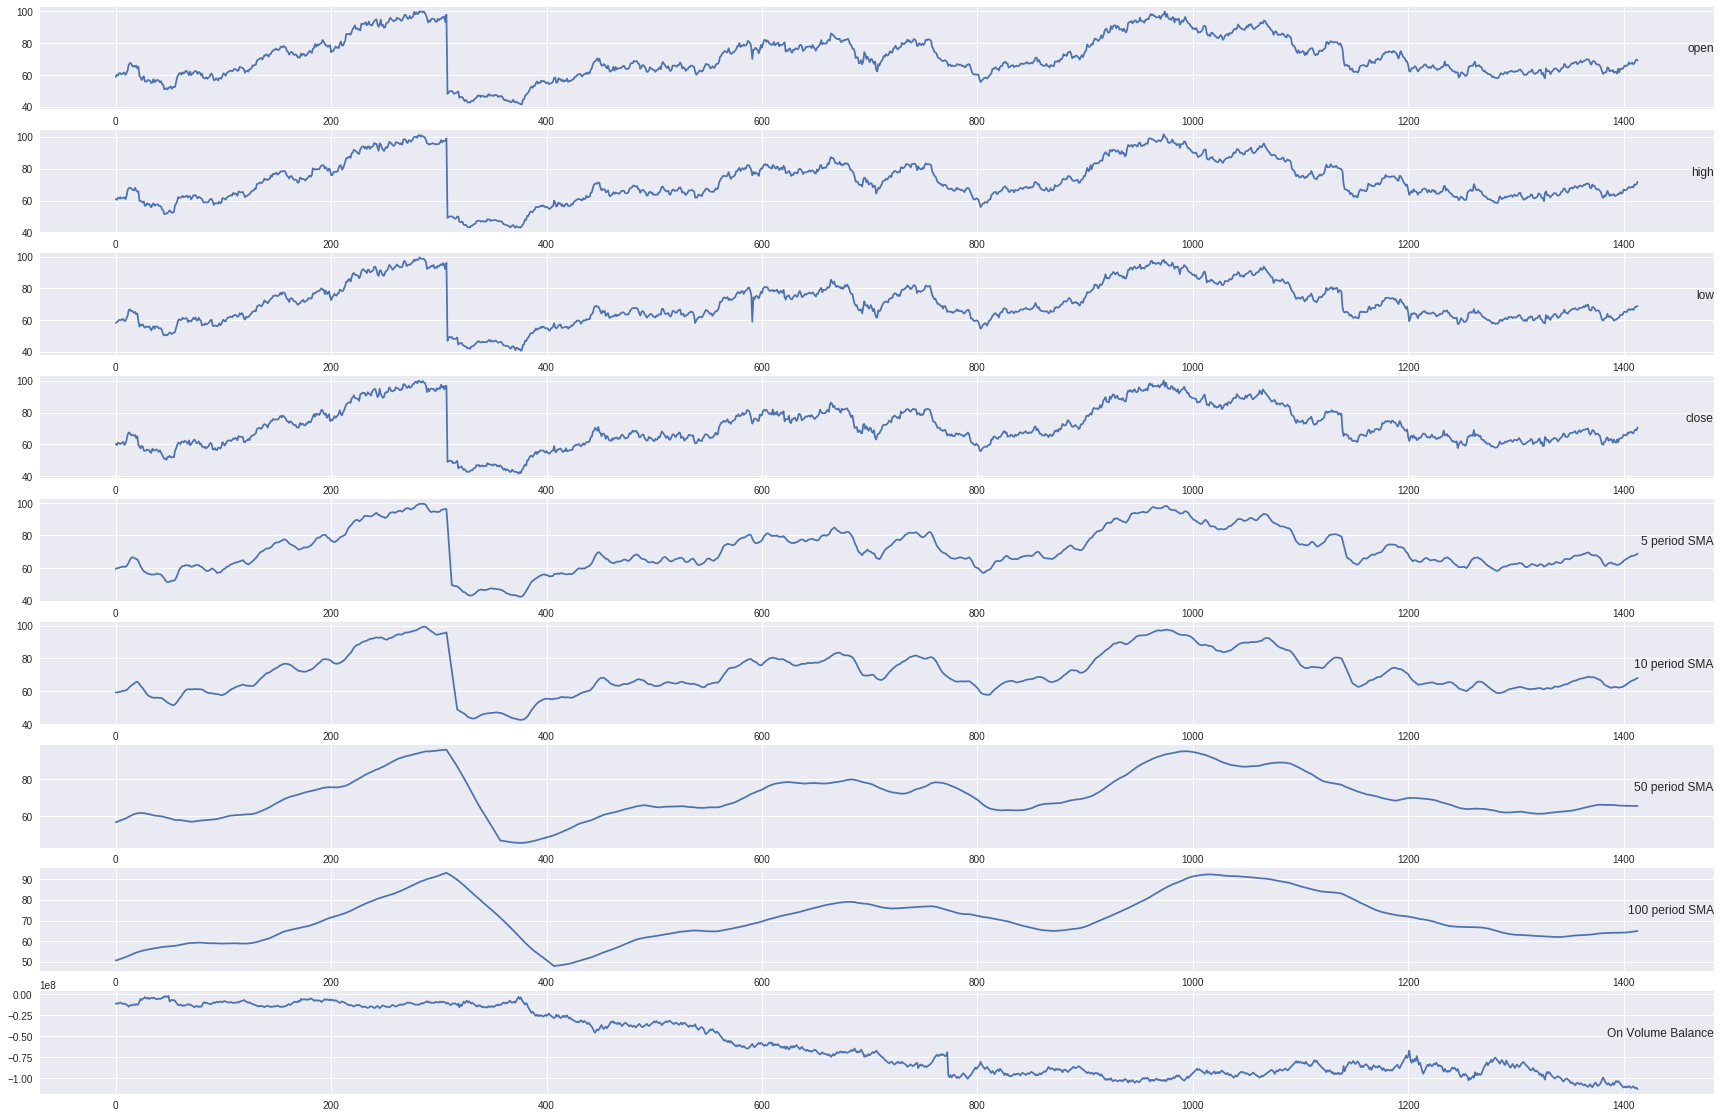

In [69]:
values = x.values
n_features = len(x.columns)

# # specify columns to plot
groups = [i for i in range(n_features)]
i = 1
# plot each column
plt.figure(figsize=(30,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(x.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [70]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    frame a time series as a supervised learning dataset.
    
    arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    return:
        Pandas DataFrame of series framed for supervised learning.
    """
        
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var(%dt-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%dt' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
  
  
values = values.astype('float32')
print(values.shape)

# change m here
m = 5
reframed = series_to_supervised(values, m, 1)

reframed.head()

(1414, 9)


var(1t-5)  var(2t-5)  var(3t-5)  var(4t-5)  var(5t-5)  var(6t-5)  \
5  58.810001  60.799999  58.139999  60.349998  59.330002  59.412998   
6  60.349998  60.450001  58.639999  59.580002  59.919998  59.349998   
7  59.689999  61.689999  59.259998  61.139999  59.924000  59.558998   
8  61.049999  61.250000  60.029999  60.880001  60.132000  59.676998   
9  61.290001  62.130001  60.110001  60.240002  60.438000  59.763000   

   var(7t-5)  var(8t-5)   var(9t-5)  var(1t-4)     ...       var(9t-1)  \
5  56.477001  50.712830 -11786400.0  60.349998     ...     -10124400.0   
6  56.712601  50.801498 -10978500.0  59.689999     ...     -10858700.0   
7  56.962002  50.990200 -11675800.0  61.049999     ...     -11534700.0   
8  57.203602  51.173401 -10811600.0  61.290001     ...     -12100700.0   
9  57.431198  51.349701 -10124400.0  60.419998     ...     -11481500.0   

       var1t      var2t      var3t      var4t      var5t      var6t  \
5  60.419998  61.230000  59.849998  60.660000  60.500000  59.915001   
6  60.680000  61.549999  60.680000  61.160000  60.816002  60.368000   
7  61.220001  61.784000  60.583500  61.639999  60.916000  60.419998   
8  61.639999  61.970001  59.360001  59.730000  60.686001  60.409000   
9  60.099998  60.849998  59.570000  60.700001  60.778000  60.608002   

       var7t      var8t       var9t  
5  57.653999  51.528801 -10858700.0  
6  57.903000  51.715401 -11534700.0  
7  58.156200  51.905899 -12100700.0  
8  58.344799  52.078499 -11481500.0  
9  58.573799  52.260300 -12307100.0  

[5 rows x 54 columns]

In [71]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(m*n_features,len(reframed.columns)) if i != m*n_features+3]], axis=1, inplace=True)
reframed.head()

var(1t-5)  var(2t-5)  var(3t-5)  var(4t-5)  var(5t-5)  var(6t-5)  \
5  58.810001  60.799999  58.139999  60.349998  59.330002  59.412998   
6  60.349998  60.450001  58.639999  59.580002  59.919998  59.349998   
7  59.689999  61.689999  59.259998  61.139999  59.924000  59.558998   
8  61.049999  61.250000  60.029999  60.880001  60.132000  59.676998   
9  61.290001  62.130001  60.110001  60.240002  60.438000  59.763000   

   var(7t-5)  var(8t-5)   var(9t-5)  var(1t-4)    ...      var(1t-1)  \
5  56.477001  50.712830 -11786400.0  60.349998    ...      61.290001   
6  56.712601  50.801498 -10978500.0  59.689999    ...      60.419998   
7  56.962002  50.990200 -11675800.0  61.049999    ...      60.680000   
8  57.203602  51.173401 -10811600.0  61.290001    ...      61.220001   
9  57.431198  51.349701 -10124400.0  60.419998    ...      61.639999   

   var(2t-1)  var(3t-1)  var(4t-1)  var(5t-1)  var(6t-1)  var(7t-1)  \
5  62.130001  60.110001  60.240002  60.438000  59.763000  57.431198   
6  61.230000  59.849998  60.660000  60.500000  59.915001  57.653999   
7  61.549999  60.680000  61.160000  60.816002  60.368000  57.903000   
8  61.784000  60.583500  61.639999  60.916000  60.419998  58.156200   
9  61.970001  59.360001  59.730000  60.686001  60.409000  58.344799   

   var(8t-1)   var(9t-1)      var4t  
5  51.349701 -10124400.0  60.660000  
6  51.528801 -10858700.0  61.160000  
7  51.715401 -11534700.0  61.639999  
8  51.905899 -12100700.0  59.730000  
9  52.078499 -11481500.0  60.700001  

[5 rows x 46 columns]

## $n$ hour prediction

In [0]:
# run this for predicting n+1 hours into future, don't run otherwise
n = 2
reframed['var4t'] = reframed.var4t.shift(-n)
reframed.dropna(inplace=True)
reframed.head()

## Normalize data

In [0]:
values = reframed.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# # scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(reframed)
# scaled = scaler.transform(reframed)

n_train_hours = int(0.75 * len(reframed.index))
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

## SVR rbf

In [0]:
# fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma='auto')

# remove timestep
# train_X_new = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# test_X_new = test_X.reshape((test_X.shape[0], test_X.shape[2]))

train_X_new = train_X
test_X_new = test_X

y_rbf = svr_rbf.fit(train_X_new, train_y,)
rbf_svr_y_predict=svr_rbf.predict(test_X_new)

In [63]:
# invert scaling for forecast
rbf_svr_y_predict = np.array([[i] for i in rbf_svr_y_predict])
print(rbf_svr_y_predict.shape)
print(test_X_new[:, :].shape)
inv_yhat = np.concatenate((rbf_svr_y_predict, test_X_new[:, :]), axis=1)
print(rbf_svr_y_predict.shape)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = values[n_train_hours:, :][:, -1]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(353, 1)
(353, 45)
(353, 1)
Test RMSE: 2.321


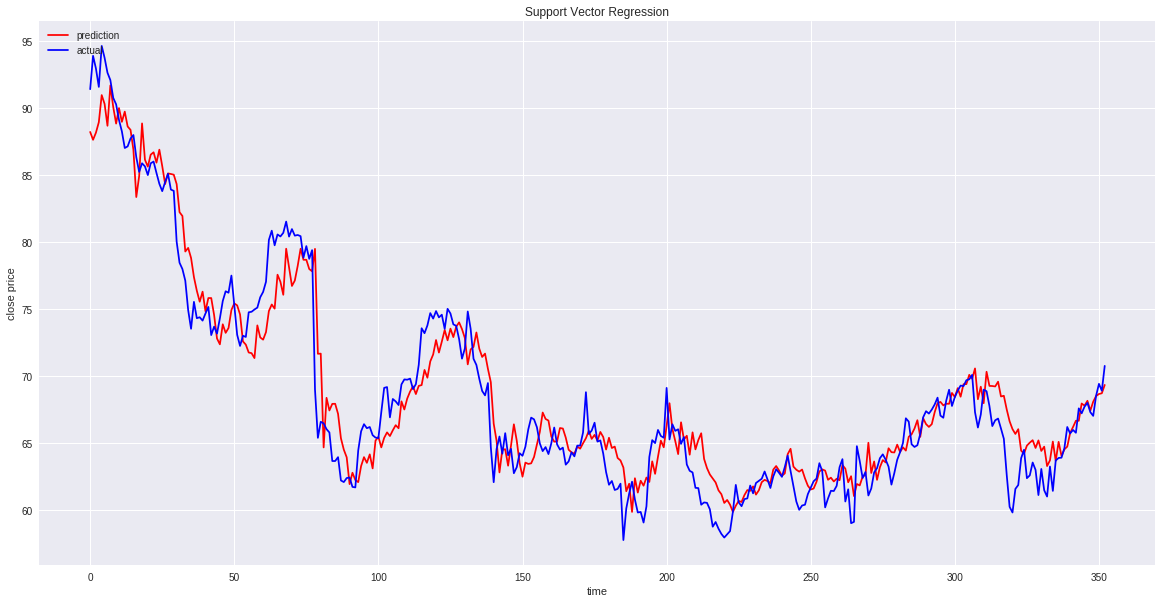

In [64]:
# Look at the results
plt.figure(figsize=(20,10))
plt.plot(inv_yhat,color='red', label='prediction')
plt.plot(inv_y,color='blue', label='actual')
plt.legend(loc='upper left')
plt.title('Support Vector Regression')
plt.xlabel('time')
plt.ylabel('close price')
plt.show()

## LSTM

In [0]:
# regression
def build_model(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        # model.compile(loss='mean_squared_error', optimizer='adam' , metrics = ['mean_squared_error'])


        return model


In [67]:
window = 1
model = build_model2([m*n_features,window,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':


(1056, 1, 45) (1056,) (353, 1, 45) (353,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 950 samples, validate on 106 samples
Epoch 1/100
 - 3s - loss: 0.2798 - acc: 0.0011 - val_loss: 0.6338 - val_acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 0.2128 - acc: 0.0011 - val_loss: 0.3284 - val_acc: 0.0000e+00
Epoch 3/100
 - 0s - loss: 0.0535 - acc: 0.0011 - val_loss: 0.0070 - val_acc: 0.0094
Epoch 4/100
 - 0s - loss: 0.0353 - acc: 0.0011 - val_loss: 0.0159 - val_acc: 0.0094
Epoch 5/100
 - 0s - loss: 0.0165 - acc: 0.0011 - val_loss: 0.0604 - val_acc: 0.0094
Epoch 6/100
 - 0s - loss: 0.0143 - acc: 0.0011 - val_loss: 0.0094 - val_acc: 0.0094
Epoch 7/100
 - 0s - loss: 0.0101 - acc: 0.0011 - val_loss: 0.0038 - val_acc: 0.0094
Epoch 8/100
 - 0s - loss: 0.0073 - acc: 0.0011 - val_loss: 0.0092 - val_acc: 0.0094
Epoch 9/100
 - 0s - loss: 0.0062 - acc: 0.0011 - val_loss: 0.0018 - val_acc: 0.0094
Epoch 10/100
 - 0s - loss: 0.0054 - acc: 0.0011 - val_loss: 0.0017 - val_acc: 0.0094
Epoch 11/100
 - 0s - loss: 0.0049 - acc: 0.0011 - val_loss: 0.0015 - val_acc: 0.0094
Epoch 12/100
 - 0s -

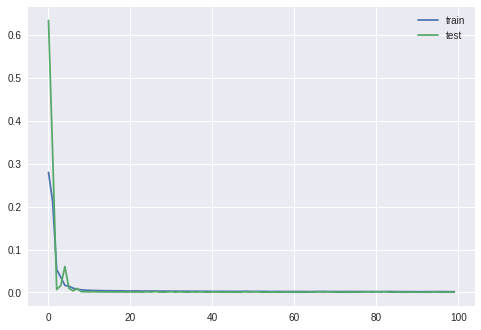

In [73]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

history = model.fit(
    train_X,
    train_y,
    batch_size=128,
    nb_epoch=100,
    validation_split=0.1,
    verbose=2)

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
test_X_new = test_X 

In [0]:
# make a prediction
yhat = model.predict(test_X_new)
test_X_new = test_X.reshape((test_X_new.shape[0], test_X_new.shape[2]))

In [76]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_new[:, :]), axis=1)
print(inv_yhat.shape)

(353, 46)


In [0]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = values[n_train_hours:, :][:, -1]

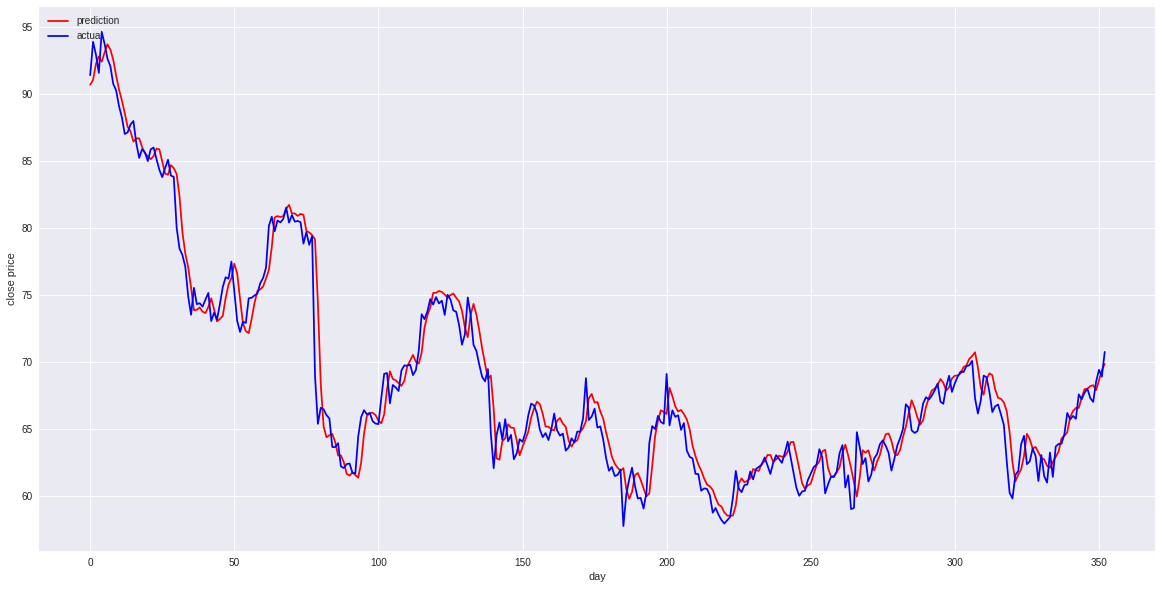

In [78]:
plt.figure(figsize=(20,10))
plt.plot(inv_yhat,color='red', label='prediction')
plt.plot(inv_y,color='blue', label='actual')
plt.legend(loc='upper left')
plt.xlabel('day')
plt.ylabel('close price')
plt.show()


In [79]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.644
